In [1]:
!pip -q install transformers #installing because we want to use pre_trained models, both from huggingface and our own models
!wget -q https://github.com/DavVratChadha/NoPunIntended/raw/main/data/het_list_processed.pickle
!wget -q https://github.com/DavVratChadha/NoPunIntended/raw/main/data/homo_list_processed.pickle
!wget -q https://github.com/DavVratChadha/NoPunIntended/raw/main/data/tag_dict.pickle
!wget -q https://github.com/DavVratChadha/NoPunIntended/raw/main/data/dataloaders_deberta.pickle
!wget -q https://github.com/DavVratChadha/NoPunIntended/raw/main/data/dataloaders_roberta.pickle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 8.1 MB/s eta 0:00:00


In [2]:
import pickle
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader
import random
from sklearn.model_selection import train_test_split
import numpy as np
from transformers import get_linear_schedule_with_warmup
from torch.optim import Adam, NAdam, SGD
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import math

In [3]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning) #ignoring UserWarning from colab because I know what I am doing here
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [4]:
# Simplify the code by creating a function to load pickle files
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f, fix_imports = True)
    return data

# Load the pickle files using the function
het_list_processed = load_pickle('het_list_processed.pickle')
homo_list_processed = load_pickle('homo_list_processed.pickle')
rel_freq = load_pickle('tag_dict.pickle')

In [5]:
print(rel_freq)

{'': 0.0003436426116838488, "''": 0.0003436426116838488, ',': 0.0003436426116838488, '-LRB-': 0.0003436426116838488, '-RRB-': 0.0003436426116838488, '.': 0.0003436426116838488, ':': 0.0003436426116838488, 'CC': 0.0003436426116838488, 'CD': 0.0010309278350515464, 'DT': 0.0003436426116838488, 'EX': 0.0003436426116838488, 'FW': 0.0006872852233676976, 'HYPH': 0.0003436426116838488, 'IN': 0.0024054982817869417, 'JJ': 0.11134020618556702, 'JJR': 0.0013745704467353953, 'JJS': 0.0013745704467353953, 'LS': 0.0003436426116838488, 'MD': 0.0013745704467353953, 'NFP': 0.0003436426116838488, 'NN': 0.3518900343642612, 'NNP': 0.07835051546391752, 'NNPS': 0.0013745704467353953, 'NNS': 0.09725085910652921, 'PDT': 0.0003436426116838488, 'POS': 0.0003436426116838488, 'PRP': 0.0006872852233676976, 'PRP$': 0.0003436426116838488, 'RB': 0.06632302405498282, 'RBR': 0.0006872852233676976, 'RBS': 0.0003436426116838488, 'RP': 0.001718213058419244, 'TO': 0.0003436426116838488, 'UH': 0.002061855670103093, 'VB': 0.0

In [6]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

mega_list = homo_list_processed + het_list_processed
#shuffling the list
random.shuffle(mega_list)


In [7]:
#mega_list is a giant list where each sublist of the following format:
#[['in/IN', 'the/DT', 'room/NN', 'the/DT', 'curtain/NNS', 'be/VBD', 'draw/VBN', ',/,', 'but/CC', 'the/DT', 'rest/NN', 'of/IN', 'the/DT', 'furniture/NN', 'be/VBD', 'real/JJ', './.'], ['In', 'the', 'room', 'the', 'curtains', 'were', 'drawn', ',', 'but', 'the', 'rest', 'of', 'the', 'furniture', 'was', 'real', '.'], ['draw/VBN']]. the first subsublist in the sublist is contains words in a sentence that have been POS tagged, second subsublist containts the original sentence, and third subsublist contains the pun word that has been POS tagged. Write code to tokenize this data, and fine tune a pretrained RoBERTa model to predict location of puns
load_dataset = True
if not load_dataset:
  input_sentences = [sublist[1] for sublist in mega_list]
  pos_sentences = [sublist[0] for sublist in mega_list]
  pun_words = [sublist[2][0] for sublist in mega_list]

  #calculating the max len for padding the inputs
  max_len = 0
  longest_joke = ""
  for sentence in input_sentences:
    if len(sentence) > max_len:
      max_len = len(sentence)
      longest_joke = " ".join(sentence) 
  max_len += 2
  print("Largest sentence in dataset has lenght = ", max_len)
  print("This joke is:\n", longest_joke)

  #creating an array of heuristic based on rel_freq mapping for each tag in dataset
  rel_freq_heuristic = []
  for sentence in pos_sentences:
    temp_heuristic = [0]
    for word in sentence:
      temp_heuristic.append(rel_freq.get(word.split("/")[1], 0))
    temp_heuristic += [0]*(max_len - len(temp_heuristic))

    rel_freq_heuristic.append(temp_heuristic)
  rel_freq_heuristic = torch.tensor(rel_freq_heuristic)

  input_ids = []
  attention_masks = []
  labels = []
  k_means_output = []
  acc_count = 0
  multiplier = 5/10

  for sentence, pun_word, pos_sentence in zip(input_sentences, pun_words, pos_sentences):
      encoded_data = tokenizer.encode_plus(
          sentence,
          add_special_tokens=True,
          max_length = max_len, #we are padding all sentences to a max_len elements (words + punction)
          pad_to_max_length = True,
          return_attention_mask = False,
          return_tensors='pt'
      )
      
      temp = np.array(encoded_data['input_ids'][0].tolist().copy())
      
      temp = temp[temp != temp[-1]] #remove padding
      num_clusters = max(math.ceil(len(temp)*multiplier), min(5, len(sentence)))

      kmeans = KMeans(n_clusters = num_clusters, n_init = 10)
      kmeans.fit(temp.reshape(-1, 1))
      att_labels = np.array(kmeans.labels_)
      k_means_output.append(kmeans.labels_)

      unique, count = (np.unique(att_labels, return_counts = True))

      idx = np.argsort(count)
      count = count[idx]
      unique = unique[idx]

      first_mode = unique[-1]
      attention_mask = torch.tensor([0] * max_len)
      indices = np.where(att_labels == first_mode)
      attention_mask[indices] = 1
      
      lone_word = unique[np.where(count == 1)]
      lone_word_ind = np.where(np.isin(att_labels, lone_word))[0]
      attention_mask[lone_word_ind] = 1

      if len(unique) > 1:
        second_lowest_chosen = unique[1]
        indices2 = np.where(att_labels == second_lowest_chosen)
        attention_mask[indices2] = 1      

      if attention_mask[pos_sentence.index(pun_word) + 1] == 0:
        acc_count += 1
                                                  
      input_ids.append(encoded_data['input_ids'][0])
      attention_masks.append(torch.tensor(attention_mask))
      labels.append(pos_sentence.index(pun_word) + 1)
      
  print("Max accuracy = ", 1 - acc_count/len(pos_sentences))

  #checking if the label index is within the range of max_len, else set it to the first word in the sentence
  labels = [label if label < max_len else 0 for label in labels]
  input_ids = torch.stack(input_ids, dim = 0)
  attention_masks = torch.stack(attention_masks, dim = 0)
  labels = torch.tensor(labels)

  #splitting the data into train, validation and test sets
  train_inputs, val_test_inputs, train_labels, val_test_labels, train_masks, val_test_masks, train_freq_heuristic, val_test_freq_heuristic = train_test_split(input_ids, labels, attention_masks, rel_freq_heuristic, random_state = seed, test_size = 0.3)
  val_inputs, test_inputs, val_labels, test_labels, val_masks, test_masks, val_freq_heuristic, test_freq_heuristic = train_test_split(val_test_inputs, val_test_labels, val_test_masks, val_test_freq_heuristic, random_state = seed, test_size = 0.5)

  #creating DataLoader
  batch_size = 1

  train_data = TensorDataset(train_inputs, train_masks, train_labels, train_freq_heuristic)
  train_dataloader = DataLoader(train_data, batch_size=batch_size)

  val_data = TensorDataset(val_inputs, val_masks, val_labels, val_freq_heuristic)
  val_dataloader = DataLoader(val_data, batch_size=batch_size)

  test_data = TensorDataset(test_inputs, test_masks, test_labels, test_freq_heuristic)
  test_dataloader = DataLoader(test_data, batch_size=batch_size)

  print(len(train_dataloader))
  print(len(val_dataloader))
  print(len(test_dataloader))

  #writing the dataloaders to a pickle file so that we can use them later while using ensembles
  with open('dataloaders_roberta.pickle', 'wb') as f:
      f.truncate(0)
      pickle.dump((train_dataloader, val_dataloader, test_dataloader), f)
  #close file
  f.close()
else:
  #load the dataloaders
  (train_dataloader, val_dataloader, test_dataloader) = load_pickle('dataloaders_roberta.pickle')
  max_len = 79
  print("Loaded presaved dataloader")

Loaded presaved dataloader


In [8]:
#function to calculate accuracy of the model for a given batch of data
def accuracy(model_output, ground_truth_labels, rel_freq_heuristic):
  model_output = torch.softmax(model_output.detach().cpu(), dim = 1) * rel_freq_heuristic.cpu()
  model_output = torch.argmax(model_output, dim=1)
  model_output = np.array(model_output)
  ground_truth_labels = np.array(ground_truth_labels.detach().cpu())

  #checking how many values in model_output are equal to their corresponding values in ground_truth_labels
  num_correct = np.sum(model_output == ground_truth_labels)
  accuracy_val = num_correct / len(ground_truth_labels)
  return accuracy_val

In [9]:
# Fine-tune the RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels = max_len)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(["Using CPU", "Using Cuda"][int(torch.cuda.is_available())])
model.to(device)

optimizer = NAdam(model.parameters(), lr = 0.00001)
epochs = 100
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Using Cuda


In [10]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

save = 1 #set to 1 to save model after every 10 epochs of training
sliding_window_width = 15 #set to the width of sliding window to check of overfitting
epochs_trained = 0 #number of epochs the model has actually been trained for

#training loop
epochs_pre_trained = 0
for epoch in tqdm(range(epochs_pre_trained, epochs_pre_trained + epochs), desc = "Training", colour = "green"):
    model.train()
    total_train_loss = 0
    total_train_acc = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels, rel_freq_heuristic = batch
        input_ids, attention_mask, labels, rel_freq_heuristic = input_ids.to(device), attention_mask.to(device), labels.to(device), rel_freq_heuristic.to(device)

        #forward pass
        outputs = model(input_ids, attention_mask = attention_mask, labels = labels)
        loss = outputs[0]
        total_train_loss += loss.item()
        #calculating accuracy for batch
        total_train_acc += accuracy(outputs[1], labels, rel_freq_heuristic)

        #backward pass
        loss.backward()

        #updating parameters
        optimizer.step()
        scheduler.step()
        model.zero_grad()

        # Delete unnecessary values to save memory
        del input_ids, attention_mask, labels, outputs, loss

    # Calculate average training loss
    avg_train_loss = total_train_loss / len(train_dataloader)
    #calculating training accuracy
    avg_train_acc = total_train_acc / len(train_dataloader)
    train_loss.append(avg_train_loss)
    train_acc.append(avg_train_acc)

    # Validation loop
    model.eval()
    total_val_loss = 0
    total_val_acc = 0
    for batch in val_dataloader:
        input_ids, attention_mask, labels, rel_freq_heuristic = batch
        input_ids, attention_mask, labels, rel_freq_heuristic = input_ids.to(device), attention_mask.to(device), labels.to(device), rel_freq_heuristic.to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            total_val_loss += loss.item()
            #calculating accuracy for batch
            total_val_acc += accuracy(outputs[1], labels, rel_freq_heuristic)
        
        #deleting unnecessary values to save memory
        del input_ids, attention_mask, labels, outputs, loss

    #calculating average validation loss
    avg_val_loss = total_val_loss / len(val_dataloader)
    avg_val_acc = total_val_acc / len(val_dataloader)
    val_loss.append(avg_val_loss)
    val_acc.append(avg_val_acc)   

    print(f"\nEpoch {epoch}\n\tTraining Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}\n\tTraining Accuracy: {avg_train_acc}, Validation Accuracy: {avg_val_acc}")

    # if (epoch + 1) % 10 == 0 and save:
    #     model.save_pretrained('roberta_model_' + str(epoch + 1) + '_epochs')
    
    #early stopping
    epochs_trained = epoch + 1
    if epoch > sliding_window_width:
        window = val_loss[epoch - sliding_window_width: epoch]
        if all(val_loss[epoch] > x for x in window):
            print(f"\nEarly stopping at epoch {epoch} due to overfitting")
            model.save_pretrained('roberta_model_' + str(epoch + 1) + '_epochs')
            break
    

Training:   1%|          | 1/100 [02:58<4:54:06, 178.25s/it]


Epoch 0
	Training Loss: 2.7906123753822967, Validation Loss: 2.169414976954738
	Training Accuracy: 0.38073852295409183, Validation Accuracy: 0.5034965034965035


Training:   2%|▏         | 2/100 [05:51<4:46:26, 175.37s/it]


Epoch 1
	Training Loss: 2.0194509342617675, Validation Loss: 1.8344426338836586
	Training Accuracy: 0.5379241516966068, Validation Accuracy: 0.578088578088578


Training:   3%|▎         | 3/100 [08:44<4:41:19, 174.02s/it]


Epoch 2
	Training Loss: 1.7779110462949452, Validation Loss: 1.6637751869509965
	Training Accuracy: 0.5893213572854291, Validation Accuracy: 0.6177156177156177


Training:   4%|▍         | 4/100 [11:37<4:38:17, 173.93s/it]


Epoch 3
	Training Loss: 1.604221014385883, Validation Loss: 1.596348577020538
	Training Accuracy: 0.6347305389221557, Validation Accuracy: 0.6643356643356644


Training:   5%|▌         | 5/100 [14:31<4:35:05, 173.74s/it]


Epoch 4
	Training Loss: 1.4720518229112862, Validation Loss: 1.634482542968991
	Training Accuracy: 0.6746506986027944, Validation Accuracy: 0.6480186480186481


Training:   6%|▌         | 6/100 [17:24<4:31:52, 173.54s/it]


Epoch 5
	Training Loss: 1.3666878111824066, Validation Loss: 1.5971683255702882
	Training Accuracy: 0.6991017964071856, Validation Accuracy: 0.6526806526806527


Training:   7%|▋         | 7/100 [20:17<4:28:37, 173.30s/it]


Epoch 6
	Training Loss: 1.2600431663566036, Validation Loss: 1.66721117979302
	Training Accuracy: 0.7320359281437125, Validation Accuracy: 0.668997668997669


Training:   8%|▊         | 8/100 [23:10<4:25:30, 173.16s/it]


Epoch 7
	Training Loss: 1.156006730453459, Validation Loss: 1.504212224604193
	Training Accuracy: 0.7430139720558883, Validation Accuracy: 0.6853146853146853


Training:   9%|▉         | 9/100 [26:02<4:22:16, 172.93s/it]


Epoch 8
	Training Loss: 1.055846611381752, Validation Loss: 1.6007764394870483
	Training Accuracy: 0.7614770459081837, Validation Accuracy: 0.682983682983683


Training:  10%|█         | 10/100 [28:53<4:18:27, 172.30s/it]


Epoch 9
	Training Loss: 0.9384509544315824, Validation Loss: 1.6085647661933602
	Training Accuracy: 0.8008982035928144, Validation Accuracy: 0.6783216783216783


Training:  11%|█         | 11/100 [31:45<4:15:23, 172.17s/it]


Epoch 10
	Training Loss: 0.8709645226161867, Validation Loss: 1.6191815063205388
	Training Accuracy: 0.812874251497006, Validation Accuracy: 0.682983682983683


Training:  12%|█▏        | 12/100 [34:37<4:12:30, 172.17s/it]


Epoch 11
	Training Loss: 0.7870605159123352, Validation Loss: 1.759597222231728
	Training Accuracy: 0.8318363273453094, Validation Accuracy: 0.696969696969697


Training:  13%|█▎        | 13/100 [37:29<4:09:28, 172.05s/it]


Epoch 12
	Training Loss: 0.6885623183912838, Validation Loss: 1.609919465548578
	Training Accuracy: 0.8547904191616766, Validation Accuracy: 0.6993006993006993


Training:  14%|█▍        | 14/100 [40:19<4:05:54, 171.56s/it]


Epoch 13
	Training Loss: 0.6285941352284218, Validation Loss: 1.6768478394121296
	Training Accuracy: 0.8707584830339321, Validation Accuracy: 0.710955710955711


Training:  15%|█▌        | 15/100 [43:10<4:02:54, 171.46s/it]


Epoch 14
	Training Loss: 0.5595098392874794, Validation Loss: 1.7677993018729374
	Training Accuracy: 0.8837325349301397, Validation Accuracy: 0.6923076923076923


Training:  16%|█▌        | 16/100 [46:02<4:00:19, 171.66s/it]


Epoch 15
	Training Loss: 0.5191484273138536, Validation Loss: 1.8599609183071568
	Training Accuracy: 0.8812375249500998, Validation Accuracy: 0.6923076923076923


Training:  17%|█▋        | 17/100 [49:04<4:01:42, 174.73s/it]


Epoch 16
	Training Loss: 0.47399685304902844, Validation Loss: 1.813021700566044
	Training Accuracy: 0.8992015968063872, Validation Accuracy: 0.6736596736596736


Training:  18%|█▊        | 18/100 [51:56<3:57:34, 173.83s/it]


Epoch 17
	Training Loss: 0.42239104567965613, Validation Loss: 1.852234826182799
	Training Accuracy: 0.9111776447105788, Validation Accuracy: 0.662004662004662

Epoch 18
	Training Loss: 0.3769001328756293, Validation Loss: 1.906113252848048
	Training Accuracy: 0.9206586826347305, Validation Accuracy: 0.675990675990676

Early stopping at epoch 18 due to overfitting


Training:  18%|█▊        | 18/100 [54:52<4:09:58, 182.91s/it]


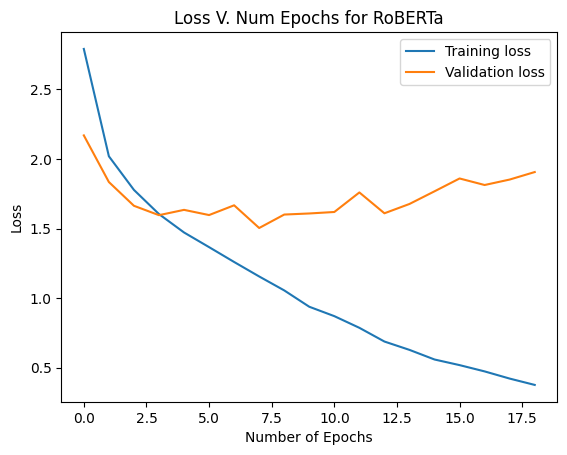

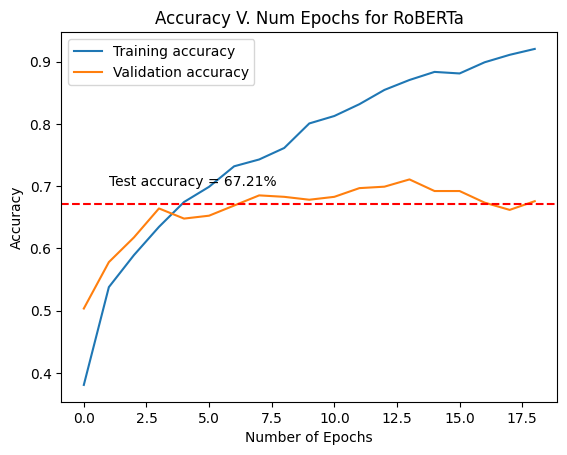

In [14]:
#plotting the training and validation loss
plt.plot(list(range(epochs_trained)), train_loss, label = 'Training loss')
plt.plot(list(range(epochs_trained)), val_loss, label = 'Validation loss')
plt.title("Loss V. Num Epochs for RoBERTa")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#plotting the training and validation accuracy
plt.plot(list(range(epochs_trained)), train_acc, label = 'Training accuracy')
plt.plot(list(range(epochs_trained)), val_acc, label = 'Validation accuracy')
plt.axhline(y = 0.672093023255814, color = 'r', linestyle = '--')
plt.annotate('Test accuracy = 67.21%', xy = (1, 0.672093023255814), xytext=(1, 0.7))
plt.title("Accuracy V. Num Epochs for RoBERTa")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [12]:
#testing loop
model.eval()
total_test_loss = 0
total_test_acc = 0
for batch in test_dataloader:
    input_ids, attention_mask, labels, rel_freq_heuristic = batch
    input_ids, attention_mask, labels, rel_freq_heuristic = input_ids.to(device), attention_mask.to(device), labels.to(device), rel_freq_heuristic.to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        total_test_loss += loss.item()
        total_test_acc += accuracy(outputs[1], labels, rel_freq_heuristic)

    #deleting unnecessary values to save memory
    del input_ids, attention_mask, labels, outputs, loss

#calculating average test loss
avg_test_loss = total_test_loss / len(test_dataloader)
avg_test_acc = total_test_acc / len(test_dataloader)
print(f"Test Loss: {avg_test_loss}")
print(f"Test Accuracy: {avg_test_acc}")

Test Loss: 1.8893946196012155
Test Accuracy: 0.672093023255814


In [13]:
print(train_loss)
print(val_loss)
print(train_acc)
print(val_acc)

# Save the training and validation loss and accuracy to a pickle file
with open('loss_acc_roberta.pickle', 'wb') as f:
    f.truncate(0)
    pickle.dump((train_loss, val_loss, train_acc, val_acc), f)
#close file
f.close()

[2.7906123753822967, 2.0194509342617675, 1.7779110462949452, 1.604221014385883, 1.4720518229112862, 1.3666878111824066, 1.2600431663566036, 1.156006730453459, 1.055846611381752, 0.9384509544315824, 0.8709645226161867, 0.7870605159123352, 0.6885623183912838, 0.6285941352284218, 0.5595098392874794, 0.5191484273138536, 0.47399685304902844, 0.42239104567965613, 0.3769001328756293]
[2.169414976954738, 1.8344426338836586, 1.6637751869509965, 1.596348577020538, 1.634482542968991, 1.5971683255702882, 1.66721117979302, 1.504212224604193, 1.6007764394870483, 1.6085647661933602, 1.6191815063205388, 1.759597222231728, 1.609919465548578, 1.6768478394121296, 1.7677993018729374, 1.8599609183071568, 1.813021700566044, 1.852234826182799, 1.906113252848048]
[0.38073852295409183, 0.5379241516966068, 0.5893213572854291, 0.6347305389221557, 0.6746506986027944, 0.6991017964071856, 0.7320359281437125, 0.7430139720558883, 0.7614770459081837, 0.8008982035928144, 0.812874251497006, 0.8318363273453094, 0.8547904